In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9

In [2]:
from pathlib import Path
print("File      Path:", Path().absolute())
print("Directory Path:", Path().absolute()) # Directory of current working directory

File      Path: /vera/u/olwitt/project
Directory Path: /vera/u/olwitt/project


In [3]:
sim = 'TNG50-4'
basePath='/virgotng/universe/IllustrisTNG/' + sim + '/output'

In [4]:
numSubs = il.groupcat.loadSubhalos(basePath,99,fields=['SubhaloPos']).shape
print(numSubs)
ids = np.arange(numSubs[0])

#load all MPBs
tree_ids = loadMPBs(basePath,99,ids=ids, fields=['SubfindID'])

(22869, 3)


In [7]:
%%time
#subhalos without a tree
for i in range(numSubs[0]):
    if i not in list(tree_ids):
        print(i)
        
#skip those subhalos

162
185
828
842
1095
1294
1505
1528
1532
1534
1582
2032
2275
2439
2498
2993
3763
15752
CPU times: user 49.6 s, sys: 568 ms, total: 50.2 s
Wall time: 50.2 s


In [43]:
print(tree_ids[10]['SubfindID'].size)

98


## step 1: save position of all subhalos at every snapshot

In [6]:
def saveAllSubhaloPos(basePath):
    f = h5py.File("files/"+basePath[32:39]+"/AllSubhaloPos.hdf5", "w") #create hdf5 file to save all subhaloPos at all snaps together
    
    #load positions for all snapshots starting at 2 (since no positions are saved before that)
    for i in range(2,100):
        subPos_atSnap = il.groupcat.loadSubhalos(basePath,i,fields=['SubhaloPos'])
        if(subPos_atSnap.size>0):
            dset = f.create_dataset(f"PosAtSnap_0{i}", subPos_atSnap.shape, dtype=float)
            dset[:] = subPos_atSnap
    f.close()
    return

In [13]:
saveAllSubhaloPos(basePath)

## step 2: convert datasets of all subs each at one snapshot into datasets of all snapshots for each subhalo

In [27]:
#functions to convert snap1(sub1,...subN), snap2(sub1,...,subN),...,snap99(sub1,...,subN) to
#sub1(snap1,...snap99), ... , subN(snap1,...,snap99)
def SubhaloPosAtAllSnaps(basePath,filename1,filename2):
    f = h5py.File(filename1, "w")
    allSubPos = h5py.File(filename2,'r')
    numSubs = il.groupcat.loadSubhalos(basePath,99,fields=['SubhaloPos']).shape
    ids = np.arange(numSubs[0])
    tree_ids = loadMPBs(basePath,99,ids=ids, fields=['SubfindID']) #load all trees to obtain indices into groupcat positions
    ds = f.create_dataset('SubhaloPos',shape=(ids.size,100,3),dtype=float)
    
    missing = []
    tree_check = list(tree_ids)
    counter = 0
    for i in range(numSubs[0]):
        if i != tree_check[counter]:
            missing.append(i)
            i+=1
            continue
        counter+=1
    i=0
    
    for i in range(ids.size):
        #if(i%100==0):
        #    print(str(i)+' ',end='')
        
        if i in missing: #if subhalo hast no tree, skip it and create dataset filled with zeros
            ds[i,:,:] = np.zeros((100,3))
            continue
            
        for j in range(99,1,-1): #no subhalo positions at snapshots 0 and 1
            if 99 - tree_ids[i]['count'] >= j: #take limited tree age into account
                break
            SubfindID = tree_ids[i]['SubfindID'][99-j]
            if(SubfindID >= len(allSubPos[f'PosAtSnap_0{j}'])): #if index larger than number of different 3d positions at that
                ds[i,99-j,:]=(0,0,0)                               #snapshot, just save as 0 and continue with next snapshot
                continue
            assert SubfindID < len(allSubPos[f'PosAtSnap_0{j}']),\
            'Subhalo: {}, SubfindID: {}, snapshot: {}, size of subhalo table at that snapshot: {}'\
            .format(i,SubfindID,j,len(allSubPos[f'PosAtSnap_0{j}']))
            
            ds[i,99-j,:] = allSubPos[f'PosAtSnap_0{j}'][SubfindID]
    f.close()
    allSubPos.close()
    return

In [28]:
%%time
SubhaloPosAtAllSnaps(basePath,'files/'+ sim +'/SubhaloPosAtAllSnaps.hdf5','files/'+ \
                     sim +'/AllSubhaloPos.hdf5')

CPU times: user 11min 9s, sys: 17.1 s, total: 11min 27s
Wall time: 11min 29s


In [22]:
f.close()
allSubPos.close()

NameError: name 'f' is not defined

## step 3: extrapolate missing or strange positions if possible

In [21]:
def linear(x,a,b):
    return a*x+b

In [22]:
def normal_condition(coord,k):
    cut = 0.1
    if k == coord.size-1 or k == coord.size: #if last value is reached, then all values before must have been nice
        return True, False
    if k <= 10:
        #check, whether coordinate differs more than cut*100% from mean up to that value
        cond = np.abs(coord[k]-np.mean(coord[:k])) <= cut*np.mean(coord[:k])
        if not cond: #when condition is not fulfilled:
            #if coordinate differs too much: try next time step -> one error is okay
            cond = np.abs(coord[k+1]-np.mean(coord[:k+1])) <= cut*np.mean(coord[:k+1])
            bad = True #but value before is labeled as 'bad'
            return cond, bad
        bad = False
    else: #if more than 10 steps already: only consider the last 10 steps (=snaps)
        cond = np.abs(coord[k]-np.mean(coord[k-10:k])) <= cut*np.mean(coord[k-10:k])
        if not cond:
            cond = np.abs(coord[k+1]-np.mean(coord[k-9:k+1])) <= cut*np.mean(coord[k-9:k+1])
            bad = True
            return cond, bad
        bad = False
    return cond, bad

In [46]:
def extrapolate_new(arr,snaps,function,boxSize):
    is_extrapolated = np.empty(arr.shape[0],dtype=bool)
    test_counter = 0
    for i in range(arr.shape[0]): #extrapolate for every subhalo...
        for j in range(3): #... and every coordinate
            coord = arr[i,:,j]
            nonzero = np.nonzero(coord)[0]
            
            bad_values = np.zeros(1) #save values differing from the mean (to not using them for fitting)
            
            k=1 #find the maximum coordiante that doesn't differ from the mean by more than 10%
            cond, bad_value = normal_condition(coord,k)
            while cond and k<=99:
                if bad_value:
                    bad_values = np.append(bad_values,k)
                k+=1
                cond, bad_value = normal_condition(coord,k)
                
            bad_values = np.trim_zeros(bad_values,'f') #delete leading 0 again
            
            if k == 99: #if there are no zeros or only single weird dips/peaks
                is_extrapolated[i] = True
                continue
            
            fit_indices = np.arange(k)
            fit_indices = np.delete(fit_indices,bad_values.astype(int))
#             if bad_values.size>1:
#                 print(bad_values)
#                 print(fit_indices)
            
            if(nonzero.shape[0]>4 and fit_indices.size > 4): #only extrapolate with four or more (good nonzero-) entries
                popt,_ = curve_fit(function,snaps[fit_indices[-10:]],coord[fit_indices[-10:]])
                is_extrapolated[i] = True
            else:
                is_extrapolated[i] = False
                continue
            
            #when slope is too steep for physical motion: stop extrapolation
            if np.abs(popt[0]) > 200:
                print(i,end=' ')
                test_counter+=1
                is_extrapolated[i] = False
                continue
                
            
            #fill gaps/non-physical values
            for index in range(k,100):
                coord[index] = function(99-index,*popt)
            #assert(np.where(coord==0)[0].shape[0]==0) #assert coordinates at all snapshots
            
            #correct for boundary crossing
            coord[np.where(coord>boxSize)] -= boxSize
            coord[np.where(coord<-boxSize)] += boxSize
            arr[i,:,j]=coord
            del popt, coord
    print(test_counter)
    return arr, is_extrapolated

In [24]:
def extrapolate_old(arr,snaps,function,boxSize):
    for i in range(arr.shape[0]): #extrapolate for every subhalo...
        for j in range(3): #... and every coordinate
            coord = arr[i,:,j]
            nonzero = np.nonzero(coord)[0]
            #max_zeros = np.arange(max(nonzero),coord.shape[0]) #since early snapshots (with possibly missing coordinates)
                                                               # can be found at high indices
            if(nonzero.shape[0]>2): #only extrapolate with three or more entries
                popt,_ = curve_fit(function,snaps[nonzero[-11:-1]],coord[nonzero[-11:-1]])
            else:
                continue
            #fill gaps/non-physical values
            for k in np.where(np.logical_or(np.logical_or(coord==0,coord>1.25*np.mean(coord[nonzero])),\
                                            coord<np.mean(coord[nonzero]/1.25)))[0]:
                coord[k] = function(99-k,*popt)
            assert(np.where(coord==0)[0].shape[0]==0) #assert coordinates at all snapshots
            
            #correct for boundary crossing
            coord[np.where(coord>boxSize)] -= boxSize
            coord[np.where(coord<-boxSize)] += boxSize
            arr[i,:,j]=coord
            del popt, coord
    return arr

In [39]:
#extrapolate positions
def extrapolatePos(filename,function,boxSize):
    f = h5py.File(filename, "r") #read file where, for every subhalo separately, all positions at every snapshot are listed
    result = h5py.File(filename[:-5] + '_extrapolated.hdf5', 'w')
    ds = result.create_dataset('SubhaloPos',f['SubhaloPos'].shape,dtype=float)
    snaps = np.arange(99,-1,-1)
    arr = f['SubhaloPos'][:,:,:]
    res, is_extrapolated = extrapolate_new(arr,snaps,function,boxSize) #extrapolate positions and save
    ds[:,:,:] = res
    ds2 = result.create_dataset('is_extrapolated',shape = is_extrapolated.shape,data = is_extrapolated)
    f.close()
    result.close()
    return is_extrapolated 

In [40]:
%%time
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
is_extrapolated = extrapolatePos('files/'+sim+'/SubhaloPosAtAllSnaps.hdf5',linear,boxSize)

250
CPU times: user 1min 28s, sys: 56 ms, total: 1min 28s
Wall time: 1min 28s


In [43]:
f = h5py.File('files/'+sim+'/SubhaloPosAtAllSnaps.hdf5', "r") 
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
snaps = np.arange(99,-1,-1)
arr = f['SubhaloPos'][:,:,:]
res, is_extrapolated = extrapolate_new(arr,snaps,linear,boxSize) #extrapolate positions and save
f.close()

111 123 142 143 187 192 202 217 234 250 252 257 265 269 278 278 283 288 329 349 420 431 473 483 493 616 713 729 752 766 772 777 779 780 780 783 784 784 821 821 870 896 899 1017 1017 1085 1089 1186 1300 1458 1558 1574 1591 1634 1638 1667 1672 1770 1800 1890 1898 1898 1912 1915 1931 1965 1965 1979 1989 2040 2047 2048 2092 2258 2402 2491 2523 2553 2647 2648 2837 2940 2965 3101 3122 3257 3454 3479 3575 3580 3772 3819 3919 4006 4021 4051 4192 4235 4435 4527 4532 4560 5013 5032 5038 5127 5290 5324 5348 5451 5539 5585 5605 6353 6353 6385 6386 6467 6483 6498 6498 6774 6860 7063 7319 7435 7484 7494 7620 7706 7752 8019 8115 8311 8353 8424 8646 8653 8781 8829 8837 8874 8920 8930 9015 9171 9257 9416 9441 9543 9597 9676 9688 9837 9848 10044 10065 10073 10109 10307 10329 10348 10381 10423 10484 10641 10687 10711 10797 10806 10806 10822 10881 10882 10991 11041 11063 11096 11155 11344 11375 11425 11642 11708 11715 11722 11804 11857 11904 12021 12025 12078 12094 12131 12181 12259 12300 12326 12371 1237

[  290   291   294 ... 22863 22867 22868]


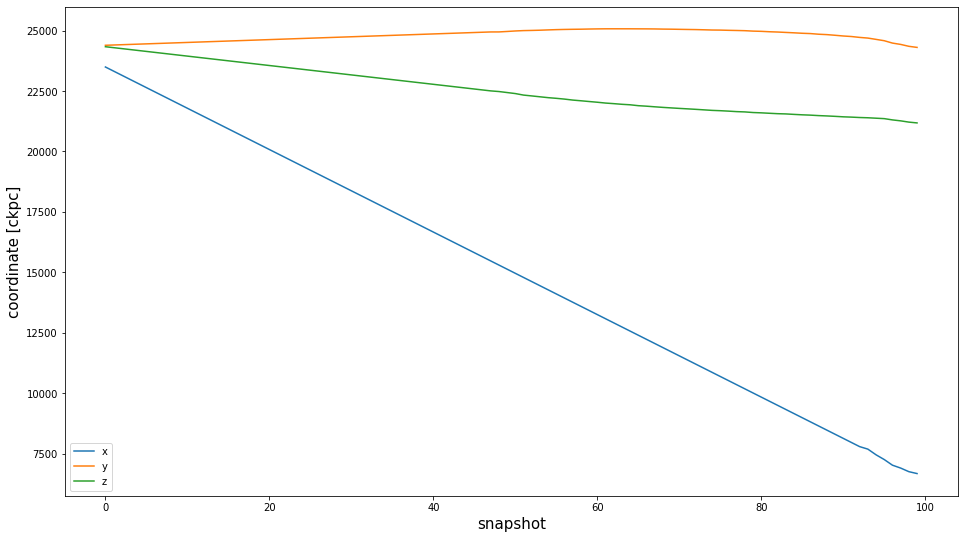

In [48]:
f = h5py.File('files/TNG50-4/SubhaloPosAtAllSnaps_extrapolated.hdf5','r')
is_extrapolated = f['is_extrapolated'][:]
print(np.where(is_extrapolated == False)[0][20:])
subID = 202
x = f['SubhaloPos'][subID,:,0]
y = f['SubhaloPos'][subID,:,1]
z = f['SubhaloPos'][subID,:,2]
snaps=np.arange(99,-1,-1)
plt.figure(figsize=(16,9))
plt.plot(snaps,x,label='x')
plt.plot(snaps,y,label='y')
plt.plot(snaps,z,label='z')
plt.legend()
plt.xlabel('snapshot',size=15)
plt.ylabel('coordinate [ckpc]',size=15)
f.close()

In [16]:
#different tests
test = h5py.File('files/'+basePath[32:39]+'/SubhaloPosAtAllSnaps_extrapolated_test.hdf5','r+')
test.attrs.modify('is_extrapolated',is_extrapolated)
print(test.attrs.__contains__('is_extrapolated'))
is_extra= test.attrs.get('is_extrapolated')
print(is_extra[:100])

test.close()

NameError: name 'is_extrapolated' is not defined

In [121]:
test.close()

In [58]:
test = il.groupcat.loadSubhalos(basePath,49,['SubhaloPos'])
print(test.shape)
print(tree_ids[470]['SubfindID'])
test_tree = il.sublink.loadTree(basePath,99,id=470,fields=['SubfindID'])
print(np.array_equal(tree_ids[470]['SubfindID'],test_tree))

(27364, 3)
[  470   459   448   454 14052 12785 15822 18570 18607 18999 18492 19602
 19899 16828 17667 17956 18450 16797 16333 13118 15880 17068 16621 18302
 17718 18386 19722 18659 20149 18165 18711 18906 20927 21211 20688 20826
 21909 20866 20662 22535 23325 24171 24355 25181 25297 25717 26315 26047
 26138 26333 25833 27602 25555]
True


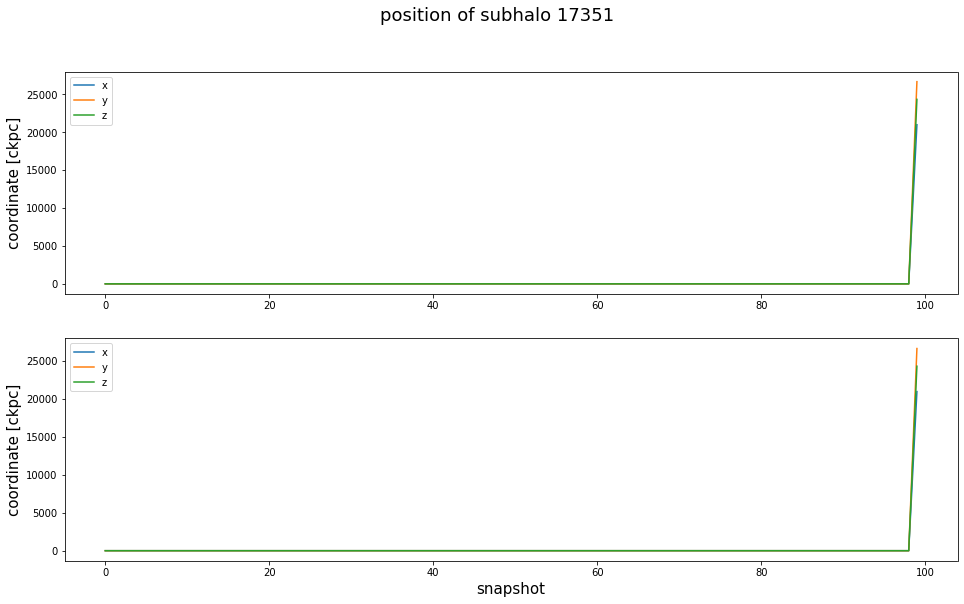

In [113]:
f = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1_extrapolated_test.hdf5','r')
g = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1.hdf5','r')

subhalo_id = 17351
x_new = f['SubhaloPos'][subhalo_id,:,0]
y_new = f['SubhaloPos'][subhalo_id,:,1]
z_new = f['SubhaloPos'][subhalo_id,:,2]

x_old = g['SubhaloPos'][subhalo_id,:,0]
y_old = g['SubhaloPos'][subhalo_id,:,1]
z_old = g['SubhaloPos'][subhalo_id,:,2]
snaps=np.arange(99,-1,-1)

fig, ax = plt.subplots(2,1)

ax[0].plot(snaps,x_old,label='x')
ax[0].plot(snaps,y_old,label='y')
ax[0].plot(snaps,z_old,label='z')
ax[0].legend()

ax[1].plot(snaps,x_new,label='x')
ax[1].plot(snaps,y_new,label='y')
ax[1].plot(snaps,z_new,label='z')
ax[1].legend()
fig.suptitle(f'position of subhalo {subhalo_id}',size=18)

ax[1].set_xlabel('snapshot',size=15)
ax[0].set_ylabel('coordinate [ckpc]',size=15)
ax[1].set_ylabel('coordinate [ckpc]',size=15)
#plt.savefig(f'pics/subhalo{subhalo_id}_position_problem.jpg',format='jpg')
#plt.scatter(snaps[77],z[77])

f.close()
g.close()

In [38]:
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
f = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1_extrapolated.hdf5','r')
coord = f['SubhaloPos'][:,:,:]
for i in range(coord.shape[0]):
    if np.where(np.logical_or(coord[i,:,:]>boxSize,coord[i,:,:]<-boxSize))[0].size>0:
        print(i)
        #pass
f.close()
#print(np.where(np.logical_or(coord[1,:,:]>boxSize,coord[1,:,:]<-boxSize)))

1
16
25
28
34
42
60
63
111
123
136
138
149
164
171
176
178
179
181
183
184
187
189
201
205
207
210
213
216
218
250
251
252
256
257
265
266
268
269
273
275
278
279
281
283
284
288
292
296
298
299
303
319
339
346
352
369
375
377
378
381
383
400
413
420
422
428
431
433
437
438
441
447
448
464
465
480
482
494
496
498
499
500
539
543
566
573
581
584
587
588
589
592
599
604
611
613
614
616
618
619
621
626
627
629
630
631
632
633
634
688
703
712
713
723
729
735
747
748
749
752
754
759
760
762
763
764
765
766
767
768
772
776
779
780
783
784
785
789
793
794
803
806
821
825
854
887
896
897
899
903
910
912
918
919
922
927
956
961
962
967
974
980
984
989
994
1004
1008
1011
1012
1013
1017
1018
1024
1025
1038
1040
1061
1062
1064
1065
1072
1078
1085
1089
1090
1091
1099
1100
1101
1121
1135
1136
1139
1140
1146
1147
1154
1160
1186
1188
1191
1196
1198
1201
1208
1211
1214
1228
1249
1253
1255
1256
1259
1264
1279
1280
1281
1282
1306
1308
1310
1315
1316
1320
1323
1325
1326
1327
1329
1347
1349
1351
1368
1370


17744
17746
17750
17751
17754
17764
17779
17780
17783
17787
17802
17803
17814
17818
17825
17827
17834
17837
17841
17844
17851
17855
17864
17867
17881
17882
17901
17905
17906
17911
17913
17916
17920
17928
17937
17943
17949
17963
17977
17985
17989
17990
17998
17999
18018
18028
18030
18034
18042
18060
18064
18066
18070
18078
18083
18084
18086
18093
18101
18103
18115
18119
18126
18132
18146
18153
18157
18162
18164
18171
18176
18192
18198
18199
18206
18207
18210
18227
18231
18233
18247
18249
18252
18265
18266
18267
18269
18271
18276
18282
18298
18300
18306
18312
18323
18328
18331
18346
18349
18352
18353
18355
18365
18366
18370
18373
18375
18378
18383
18384
18397
18400
18404
18405
18412
18413
18414
18418
18422
18427
18428
18430
18442
18447
18449
18462
18464
18466
18481
18488
18490
18495
18498
18503
18504
18505
18509
18515
18520
18542
18547
18554
18556
18557
18562
18566
18571
18572
18574
18580
18581
18585
18586
18589
18590
18595
18601
18604
18611
18620
18624
18648
18651
18652
18653
18660
1866

[ 7131.75830078  7135.30957031  7147.24902344  7158.34130859
  7179.2578125   7195.19628906  7220.03271484  7238.25341797
  7265.43115234  7283.32763672  7308.66992188  7332.94091797
  7347.50927734  7365.79833984  7374.68847656  7378.76367188
  7369.62255859  7354.61523438  7316.59814453  7258.79492188
  7133.50048828  8498.96582031  7122.45703125  7089.44140625
  7062.21972656  7046.78417969  7055.046875    7018.09765625
  7179.4453125   6784.29541016  7024.20703125  7042.40332031
  7071.58544922  7250.19677734  7507.30566406  7530.91943359
  6787.11328125  7062.92382812  7527.41113281  7640.64013672
  7795.39160156  7742.74121094  7732.65185547  7362.8984375
  7616.34033203  7045.72314453  7587.95898438  7583.52539062
  6702.54101562  8219.50976562  7509.90136719  7388.87109375
  8476.046875    6665.91845703  9375.52050781  1366.39550781
 11746.13378906 23773.83984375  2531.55712891 24507.51367188
  7850.56982422 25183.29492188 32485.41992188 31173.40039062
 13568.50976562 14316.790

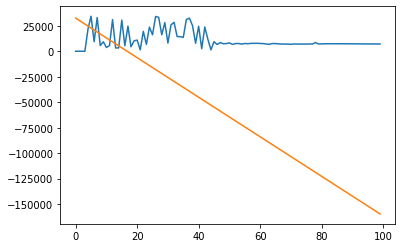

In [45]:
f = h5py.File('files/SubhaloPosAtAllSnaps_v2-Copy1.hdf5','r')
x = f['SubhaloPos'][28,:,0]
print(x)
print(x.nonzero()[0])
plt.plot(snaps,x)
popt, _ = curve_fit(linear,snaps[x.nonzero()[0][-10:-1]],x[x.nonzero()[0][-10:-1]])
plt.plot(snaps,linear(snaps,*popt))
f.close()

[-1940.37261567 32478.20773486]
32478.20773486332
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92,
       94, 95, 96, 97, 98, 99]),)


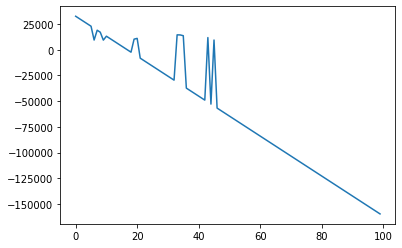

In [46]:
print(popt)
print(linear(0,*popt))
expr =np.where(np.logical_or(np.logical_or(x==0,x>4/3*np.mean(x[np.nonzero(x)[0]])),\
                                            x<np.mean(x[np.nonzero(x)[0]])*3/4))
print(expr)
for i in expr[0]:
    x[i] = linear(99-i,*popt)
plt.plot(snaps,x)

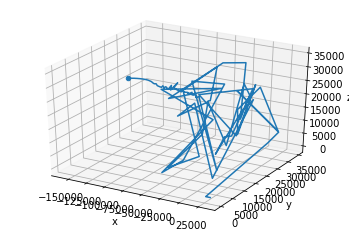

In [47]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure().add_subplot(projection='3d')
ax.plot(x, y, z)
ax.scatter(x[0],y[0],z[0])
ax.set(xlabel='x',ylabel='y',zlabel='z')
plt.show()

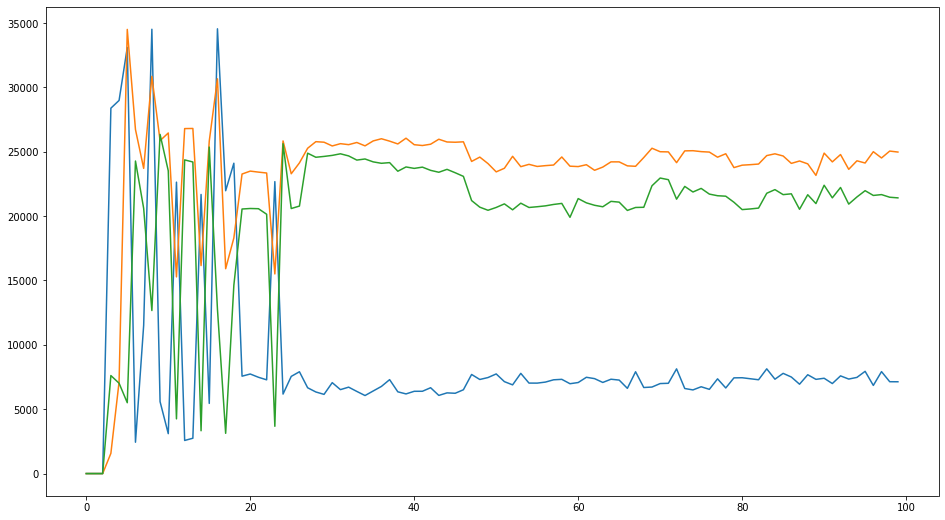

In [62]:
pos = np.zeros((100,3))
for i in range(99,2,-1):
    #print(i)
    coord = il.groupcat.loadSubhalos(basePath,i,fields=['SubhaloCM'])
    coord = coord[28,:]
    pos[i,:] = coord
snaps=np.arange(100)
plt.figure(figsize=(16,9))
plt.plot(snaps,pos[:,0])
plt.plot(snaps,pos[:,1])
plt.plot(snaps,pos[:,2])
